<a href="https://colab.research.google.com/github/YeongRoYun/BearTeam/blob/dev/data/datasets/COCO_Converter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=614

위의 형식을 COCO Format으로 재구성합니다.

```
{
"info": info, "images": [image], "annotations": [annotation], "licenses": [license],
}

info{
"year": int, "version": str, "description": str, "contributor": str, "url": str, "date_created": datetime,
}

image{
"id": int, "width": int, "height": int, "file_name": str, "license": int, "flickr_url": str, "coco_url": str, "date_captured": datetime,
}

license{
"id": int, "name": str, "url": str,
}
```

```
annotation{
"id": int, "image_id": int, "category_id": int, "segmentation": RLE or [polygon], "area": float, "bbox": [x,y,width,height], "iscrowd": 0 or 1,
}

categories[{
"id": int, "name": str, "supercategory": str,
}]
```

- AI-HUB 데이터의 BBOX를 확인했을 때, x_min,y_min, w, h의 형식을 동일하게 유지하였다.

In [ ]:
import gc
import os
import re
import json
import random
import subprocess
import numpy as np
from tqdm import tqdm
from PIL import Image as PILImage

from pathlib import Path
from datetime import datetime
from PIL.Image import Resampling
from enum import Enum, unique, auto


from typing import List, Dict, Tuple, Optional
from pydantic import BaseModel


class ConvertConfig(BaseModel):
    """
    src : 원본 데이터셋의 최상위 폴더
    dest : 변환될 데이터셋이 저장될 최상위 폴더
    width: resize될 width
    height: resize될 height
    numSample: 추출할 샘플 수
    """
    src: Path
    dest: Path
    width: int
    height: int
    numSample: int

class Info(BaseModel):
    year: int
    version: str
    description: str
    contributor: str
    url: str
    date_created: str
        
class Image(BaseModel):
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
        

class License(BaseModel):
    id: int
    name: str
    url: str

class Annotation(BaseModel):
    id: int
    image_id: int
    category_id: int
    bbox: Tuple[float, float, float, float] # x_min, y_min, w, h

class Category(BaseModel):
    id: int
    name: str
    supercategory: str
        
class COCOFormat(BaseModel):
    info: Info
    categories: List[Category]
    images: List[Image]
    annotations: List[Annotation]
    licenses: List[License]

        
@unique
class CategoryEnum(Enum):
    DONTCARE = auto()
    BICYCLE = auto()
    MOTORCYCLE = auto()
    KICKBOARD = auto()

    def __str__(self):
        if self == CategoryEnum.DONTCARE:
            return 'dontcare'
        elif self == CategoryEnum.BICYCLE:
            return 'bicycle'
        elif self == CategoryEnum.MOTORCYCLE:
            return 'motorcycle'
        elif self == CategoryEnum.KICKBOARD:
            return 'kickboard'
        else:
            return 'Not defined'

    def __int__(self):
        if self == CategoryEnum.DONTCARE:
            return 0
        elif self == CategoryEnum.BICYCLE:
            return 1
        elif self == CategoryEnum.MOTORCYCLE:
            return 2
        elif self == CategoryEnum.KICKBOARD:
            return 3
        else:
            return -1
        
class Converter:
    def __init__(self, config:ConvertConfig, train=True):
        self.config = config
        self.train = train
        self.trainPath = self.config.dest / 'Training'
        self.validPath = self.config.dest / 'Validation'
        
        self.logPath = self.config.dest / 'converter.log'
        
        self.imgPath = self.currentDirectory / 'images'
        self.annoPath = self.currentDirectory / 'annotations'
        
        self.annoDest = self.annoPath / 'main.txt' # 'main.json'
        
    @property
    def currentDirectory(self):
        return self.trainPath if self.train else self.validPath
        
    def run(self):
        """
        File I/O가 많으므로 링크가 끊긴 fd를 명시적으로 제거한다.
        """
        gc.collect()
        isMade = self._make_dirs()
        
        with open(self.logPath, 'w') as fd:
            fd.write(f"Start converting from {self.config.src}\n")
            fd.write(f"Mode: {'Train' if self.train else 'Validation'}\n")
            fd.write(f"Saved at {self.currentDirectory}\n")
            
            if not isMade:
                fd.write(f"Can't make {self.currentDirectory}...\n")
                return None
            
            if not self._is_continue(fd):
                return None
            
            fd.write(f"Running...\n")
            info = self._get_info(fd)
            categories = self._get_categories(fd)
            licenses = self._get_licenses(fd)
            
            gc.collect()
            images, annotations = self._get_imgs_and_annos(fd)
            gc.collect()
            
            # Build
            # fd.write("Build main.json...")
            fd.write("Build main.txt...")
            main = COCOFormat(info=info, categories=categories, images=images, \
                              annotations=annotations, licenses = licenses)
            
            with open(self.annoDest, 'w') as destFD:
                destFD.write(main.json())
            fd.write("Done!!\n")
        
            fd.write("Finish convert!!!\n")
            fd.write("Have a nice day!!!\n")
            print("End!!")
            gc.collect()
        return None
            
                
    def _is_continue(self, fd)->bool:
        answer = ''
        while answer not in {'yes', 'no'}:
            answer = input("Continue?(yes/no) ")
        if answer == 'yes':
            return True
        elif answer == 'no':
            fd.write(f"Thank you... Have a nice day!")
            return False
    
    def _make_dirs(self)->bool:
        if self.currentDirectory.exists():
            ret = subprocess.run(['rm', '-rf', self.currentDirectory])
            if ret.returncode == 0:
                os.makedirs(self.currentDirectory, exist_ok=True)
                os.makedirs(self.imgPath, exist_ok=True)
                os.makedirs(self.annoPath, exist_ok=True)
                return True
            else:
                return False
        else:
            os.makedirs(self.currentDirectory, exist_ok=True)
            os.makedirs(self.imgPath, exist_ok=True)
            os.makedirs(self.annoPath, exist_ok=True)  
            return True
    
    def _get_info(self, fd)->Info:
        fd.write(f"Make info...")
        info = Info(year = 2022, version = 1, description="AI-HUB Dataset", contributor="에프원소프트", \
                   url=r'https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=614', \
                   date_created=str(datetime.now()).split()[0].replace('-', '/'))
        fd.write(f"Done!!\n")
        return info
    
    def _get_categories(self, fd)->List[Category]:
        fd.write(f"Make categories...")
        categories = [Category(id=int(category), name=str(category), supercategory=str(category)) \
                    for category in CategoryEnum]
        fd.write(f"Done!!\n")
        return categories
    
    def _get_licenses(self, fd)->List[License]:
        fd.write(f"Make licenses...")
        licenses = [License(id=0, name="AI-HUB License", url="https://www.aihub.or.kr/")]
        fd.write(f"Done!!\n")
        return licenses
    
    def _get_imgs_and_annos(self, fd)->Tuple[List[Image], List[Annotation]]:
        """
        numSample을 사용해서 갯수 선택!
        """
        fd.write(f"Make images and annotations...\n")

        fd.write(f"Get rawPaths to {self.annoPath}(format: json)...")
        annoList = subprocess.run(['find', self.config.src, '-name', '*.json'], \
                                 capture_output=True).stdout.decode('utf-8').strip().split('\n')
        fd.write(f"Done!\n")
        
        if len(annoList) < self.config.numSample:
            fd.write(f"{self.config.numSample} is greater than the total number of files...\n")
            fd.write(f"Select total files!...\n")
            self.config.numSample = len(annoList)
        elif self.config.numSample < 0:
            fd.write(f"{self.config.numSample} is less than 0...\n")
            fd.write(f"Selecto total files!...\n")
            self.config.numSample = len(annoList)
        
        fd.write(f"Select {self.config.numSample}...")
        random.shuffle(annoList)
        fd.write(f"Done!\n")
        
        fd.write(f"Copy Images and Annotations...")
        print("Copy Images and Annotations...")
        for rawAnnoPath in tqdm(annoList[:self.config.numSample]):
            gc.collect()
            
            rawImgPath = rawAnnoPath.strip().split('/')
            rawImgPath[1] = '원천데이터'
            rawImgPath = '/'.join(rawImgPath)
            rawImgPath = re.sub(r'json', r'jpg', rawImgPath)
            
            ret = subprocess.run(['cp', rawImgPath, self.imgPath])
            if ret.returncode == 0:
                # Image 복사가 성공!
                subprocess.run(['cp', rawAnnoPath, self.annoPath])
        fd.write(f"Done!\n")
            
            
        fd.write(f"Convert annotations and images...\n")
        print(f"Convert annotations and images...")

        images: List[Image] = []
        annotations: List[Annotation] = []
        
        total = 0
        checkFormat = lambda file: True if re.match(r'.*\.json', str(annoFile)) and not re.match(r'.*/main.json', str(annoFile)) else False
        
        for cnt, annoFile in tqdm(enumerate(self.annoPath.iterdir())):
            # cnt를 img와 anno의 공통 id로 사용한당
            gc.collect()
            
            if not checkFormat(annoFile):
                continue
                
            total += 1

            with open(annoFile, 'r') as annoFD:
                anno = json.load(annoFD)
                name = re.search(r'(.*)\.json', annoFile.name)[1]
                
                if not self._process_img(name):
                    fd.write(f"INVALID: {name}\n")
                    continue
                
                infos = self._process_anno(anno)
                if not infos:
                    fd.write(f"INVALID: {name}\n")
                    continue
                
                # Create Image and Annotation
                image = Image(id=cnt, width=self.config.width, height=self.config.height, \
                              file_name=name + '.jpg', license=0, \
                              date_captured=anno['info'].get('date', str(datetime.now())))
                images.append(image)
                
                for category, bbox in infos:
                    annotation = Annotation(id=cnt, image_id=image.id, category_id=category, bbox=bbox)
                    annotations.append(annotation)
            
            if (cnt + 1) % 10000 == 0:
                fd.write(f"{cnt + 1} Processed...\n")
        
        fd.write(f"Total: {total} processed...\n")
        
        # Clean
        fd.write(f"Clean files...")
        for annoFile in self.annoPath.iterdir():
            if annoFile != self.annoDest:
                subprocess.run(['rm', annoFile])
        
        fd.write(f"Done!!\n")
        
        gc.collect()
        return images, annotations
    
    def _process_img(self, name)->bool:
        """
        Resize
        """
        gc.collect()
        
        url = self.imgPath / (name + '.jpg')
        if url.exists():
            img = PILImage.open(url)
            img = img.resize((self.config.width, self.config.height), Resampling.BICUBIC)
            img.save(url)
            return True
        else:
            return False
    
    def _process_anno(self, anno) -> Optional[List[Tuple[int, Tuple[float, float, float, float]]]]:
        """
        Return: list(category_id, bbox_info)
        """
        rawWidth = anno['description']['imageWidth']
        rawHeight = anno['description']['imageHeight']
        
        PMs = {
            CategoryEnum.MOTORCYCLE: set(range(13, 20)), # [13, 19]
            CategoryEnum.BICYCLE: set(range(20, 28)), # [20, 27]
            CategoryEnum.KICKBOARD: set(range(28, 37)), # [28, 36]
        }
            
        
        # Resize bbox
        try:
            ret = []
            category = int(CategoryEnum.DONTCARE)
            for obj in anno['annotations']['PM']:
                for PM in PMs.keys():
                    if int(obj['PM_code']) in PMs[PM]:
                        category = int(PM)
                        
                bbox = np.array(obj['points'], dtype=np.float32)
                bbox[0] = bbox[0] / float(rawWidth) * float(self.config.width)
                bbox[1] = bbox[1] / float(rawHeight) * float(self.config.height)
                bbox[2] = bbox[2] / float(rawWidth) * float(self.config.width)
                bbox[3] = bbox[3] / float(rawHeight) * float(self.config.height)
                
                ret.append((category, bbox.tolist()))
            return ret
                
        except KeyError:
            # 하나거나, 없거나
            print(anno['annotations']['PM'])
            if 'points' not in anno['annotations']['PM'].keys():
                return None
            else:
                obj = anno['annotations']['PM']
                
                category = int(CategoryEnum.DONTCARE)
                for obj in anno['annotations']['PM']:
                    for PM in PMs.keys():
                        if int(obj['PM_code']) in PMs[PM]:
                            category = int(PM)
                
                bbox = np.array(obj['points'], dtype=np.float32)
                bbox[0] = bbox[0] / float(rawWidth) * float(self.config.width)
                bbox[1] = bbox[1] / float(rawHeight) * float(self.config.height)
                bbox[2] = bbox[2] / float(rawWidth) * float(self.config.width)
                bbox[3] = bbox[3] / float(rawHeight) * float(self.config.height)
                
                return [(category, bbox.tolist())]



In [ ]:
def testLogic():
    config = ConvertConfig(src='Sample', dest='Target', width=600, height=600, numSample=10)
    converter = Converter(config)
    converter.run()

testLogic()

Continue?(yes/no) yes
Copy Images and Annotations...


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 24.33it/s]


Convert annotations and images...


10it [00:00, 10.93it/s]


End!!


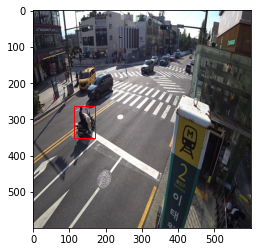

In [ ]:
# Check
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def testBBOX():
    with open('Target/Training/annotations/main.json') as fd:
        anno = json.load(fd)
#         print(json.dumps(anno, indent=4))

        img = PILImage.open(Path('Target/Training/images') / anno['images'][0]['file_name'])
        plt.imshow(img)
        ax = plt.gca()

        bbox =  anno['annotations'][0]['bbox']
        rect = Rectangle(bbox[:2], bbox[2], bbox[3], edgecolor='red', fill=False)
        ax.add_patch(rect)

testBBOX()